### Imports
First let's import all of the relevant packages. make sure you installed all of the necessary packages from the env.yaml file

In [1]:
import torch
from torchvision import datasets
from torchvision import transforms
from torchvision.transforms import RandomCrop
from torchvision.transforms import RandomApply
from torchvision.transforms import RandomAffine
from torchvision.transforms import RandomRotation
from torchvision.transforms import Grayscale
from torchvision.transforms import ToTensor
from torchvision.transforms import Resize
from torchvision.transforms import RandomHorizontalFlip
from torchvision.transforms import ColorJitter
from torch.utils.data import random_split
from torch.utils.data import DataLoader
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt
from HowIFeel import HowIFeel
import torch.nn as nn
from TrainModel import train_model
import Config as cfg
from tools import show_examples
from tools import plot_confusion_matrix
from tools import print_hyper_params
import optuna

### Device
Now we determine on which device we will run (Supporting MPS and CPU)

In [2]:
device = cfg.GPU_STR if torch.has_mps else "cpu"
print(f"[INFO] Current training device: {device}")

[INFO] Current training device: mps


### Data Augmentations
In this section we will define the augmentations that we use for the training and for the validation and test sets

In [3]:
train_transform = transforms.Compose([
    Resize((cfg.IMAGE_HEIGHT, cfg.IMAGE_WIDTH)),
    Grayscale(num_output_channels=cfg.NUM_INPUT_CHANNELS),
    RandomHorizontalFlip(),
    RandomApply([transforms.RandomAffine(0, translate=(0.2, 0.2))], p=0.5),
    ColorJitter(),
    ToTensor()
])

test_transform = transforms.Compose([
    Resize((cfg.IMAGE_HEIGHT, cfg.IMAGE_WIDTH)),
    Grayscale(num_output_channels=cfg.NUM_INPUT_CHANNELS),
    ToTensor()
])

### Dataset

Now it's time to load the data from the dataset folder, split it to validation, training and test sets, we will show how many examples are in each class and show examples of images from the dataset

[INFO] Class labels: ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']
[INFO] Number of Training Samples = 25838
[INFO] Number of Validation Samples = 2871
[INFO] Number of total Samples = 28709
[INFO] Total sample: Counter({3: 6485, 4: 4418, 5: 4363, 2: 3684, 0: 3632, 6: 2862, 1: 394})
[INFO] Train Data Summarize:
[INFO] 	Emotion: Neutral, Samples: 4418
[INFO] 	Emotion: Sad, Samples: 4363
[INFO] 	Emotion: Surprise, Samples: 2862
[INFO] 	Emotion: Angry, Samples: 3632
[INFO] 	Emotion: Fear, Samples: 3684
[INFO] 	Emotion: Happy, Samples: 6485
[INFO] 	Emotion: Disgust, Samples: 394
[INFO] Hyper Parameters:
[INFO] 	Train Portion = 0.9
[INFO] 	Validation Portion = 0.1
[INFO] 	Number Of Epochs = 50
[INFO] 	Batch Size = 64
[INFO] 	Learning Rate = 0.01
[INFO] 	Optimizer = SGD
[INFO] 	Using Scheduler = True
[INFO] 		Scheduler Paitence = 5
[INFO] 		Minimum Learning Rate = 1e-06
[INFO] 		Reduce Factor = 0.75
[INFO] 	Using Early Stopping = False


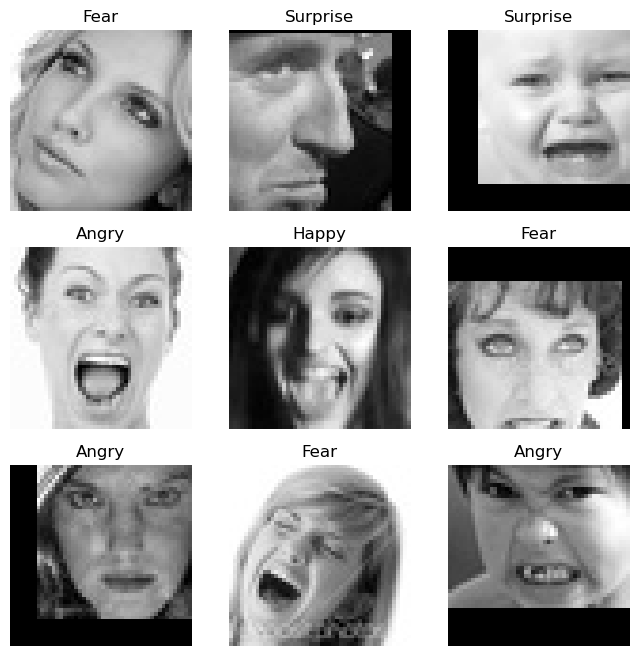

In [4]:
# load all the images within the specified folder and apply different augmentation
train_data = datasets.ImageFolder(cfg.TRAIN_DIRECTORY, transform=train_transform)
test_data = datasets.ImageFolder(cfg.TEST_DIRECTORY, transform=test_transform)

classes = train_data.classes
print(f"[INFO] Class labels: {classes}")
# use train samples to generate train/validation set
num_train_samples = len(train_data)
train_size = int(np.floor(num_train_samples * cfg.TRAIN_SIZE))
val_size = int(np.ceil(num_train_samples * cfg.VAL_SIZE))

print(f'[INFO] Number of Training Samples = {train_size}')
print(f'[INFO] Number of Validation Samples = {val_size}')
print(f'[INFO] Number of total Samples = {num_train_samples}')
assert train_size + val_size == num_train_samples

# randomly split the training dataset into train and validation set
train_data, val_data = random_split(train_data, [train_size, val_size])

# modify the data transform applied towards the validation set
val_data.dataset.transforms = test_transform

# get the labels within the training set
train_classes = [label for _, label in train_data]

# count each labels within each classes
class_count_train = Counter(train_classes)
print(f"[INFO] Total sample: {class_count_train}")
print(f'[INFO] Train Data Summarize:')
for label, num_samples in class_count_train.items():
    print(f'[INFO] \tEmotion: {cfg.CODE_TO_STR[label]}, Samples: {num_samples}')
# A tools function to pretty print all of the hyper parameters from the Config file
print_hyper_params()
train_loader = DataLoader(train_data, batch_size=cfg.BATCH_SIZE)
val_loader = DataLoader(val_data, batch_size=cfg.BATCH_SIZE)
test_loader = DataLoader(test_data, batch_size=cfg.BATCH_SIZE)

# Visualize a few images from the data
show_examples(train_data)

### Model
Now we will define the model to be trained, it will be determined by the different available options from the config file, and it might use transfer learning if feature extract is enabled

In [5]:
is_pre_trained = False if cfg.MODEL == cfg.PERSONAL_1 or cfg.MODEL == cfg.PERSONAL_2 or cfg.MODEL == cfg.PERSONAL_3 or cfg.MODEL == cfg.PERSONAL_VGG else True
model = HowIFeel(is_pre_trained=is_pre_trained)
model = model.to(device)

# Gather the parameters to be optimized/updated in this run. If we are
#  fine-tuning we will be updating all parameters. However, if we are
#  doing feature extract method, we will only update the parameters
#  that we have just initialized, i.e. the parameters with requires_grad
#  is True.
params_to_update = model.parameters()
if is_pre_trained:
    print(params_to_update)
    print("[INFO] Params to learn:")
    if cfg.FEATURE_EXTRACT:
        params_to_update = []  # override the initial list definition above
        for name, param in model.named_parameters():
            if param.requires_grad:
                params_to_update.append(param)
                print(f"[INFO] \t{name}")
    else:
        for name, param in model.named_parameters():
            if param.requires_grad:
                print(f"[INFO] \t{name}")
else:
    print('[INFO] Network Architecture:')
    print(model)
# Observe that all parameters are being optimized

<generator object Module.parameters at 0x1558a20a0>
[INFO] Params to learn:
[INFO] 	model.conv1.weight
[INFO] 	model.bn1.weight
[INFO] 	model.bn1.bias
[INFO] 	model.layer1.0.conv1.weight
[INFO] 	model.layer1.0.bn1.weight
[INFO] 	model.layer1.0.bn1.bias
[INFO] 	model.layer1.0.conv2.weight
[INFO] 	model.layer1.0.bn2.weight
[INFO] 	model.layer1.0.bn2.bias
[INFO] 	model.layer1.1.conv1.weight
[INFO] 	model.layer1.1.bn1.weight
[INFO] 	model.layer1.1.bn1.bias
[INFO] 	model.layer1.1.conv2.weight
[INFO] 	model.layer1.1.bn2.weight
[INFO] 	model.layer1.1.bn2.bias
[INFO] 	model.layer2.0.conv1.weight
[INFO] 	model.layer2.0.bn1.weight
[INFO] 	model.layer2.0.bn1.bias
[INFO] 	model.layer2.0.conv2.weight
[INFO] 	model.layer2.0.bn2.weight
[INFO] 	model.layer2.0.bn2.bias
[INFO] 	model.layer2.0.downsample.0.weight
[INFO] 	model.layer2.0.downsample.1.weight
[INFO] 	model.layer2.0.downsample.1.bias
[INFO] 	model.layer2.1.conv1.weight
[INFO] 	model.layer2.1.bn1.weight
[INFO] 	model.layer2.1.bn1.bias
[INFO] 	

### Train
Training the model

In [6]:
if cfg.OPTIMIZER == 'SGD':
    optimizer = torch.optim.SGD(params_to_update, lr=cfg.LR, momentum=cfg.MOMENTUM, nesterov=True, weight_decay=cfg.WEIGHT_DECAY)
elif cfg.OPTIMIZER == 'Adam':
    optimizer = torch.optim.Adam(params_to_update, lr=cfg.LR, weight_decay=cfg.WEIGHT_DECAY)
else:
    raise NotImplementedError
data_loaders = {'train': train_loader, 'val': val_loader}
criterion = nn.CrossEntropyLoss()
if cfg.USE_OPTUNA:
    sampler = optuna.samplers.TPESampler()
    study = optuna.create_study(study_name="FER-2013", direction="maximize", sampler=sampler)
    study.optimize(lambda trial: train_model(trial, data_loaders, criterion), n_trials=20, timeout=600)
    pruned_trials = [t for t in study.trials if t.state == optuna.trial.TrialState.PRUNED]
    complete_trials = [t for t in study.trials if t.state == optuna.trial.TrialState.COMPLETE]
    print("Study statistics: ")
    print("  Number of finished trials: ", len(study.trials))
    print("  Number of pruned trials: ", len(pruned_trials))
    print("  Number of complete trials: ", len(complete_trials))
    print("Best trial:")
    trial = study.best_trial
    print("  Value: ", trial.value)
    print(" Params: ")
    for key, value in trial.params.items():
        print(" {}: {}".format(key, value))
    optuna.visualization.plot_param_importances(study)
    exit(1)
else:
    model, _, history = train_model(model, data_loaders, criterion, optimizer)

Epoch 0/49
----------


100%|██████████| 404/404 [00:24<00:00, 16.72it/s]



Learning Rate = 0.010000, Training Loss = 1.7205, Training Accuracy = 0.3180


100%|██████████| 45/45 [00:01<00:00, 28.44it/s]



Learning Rate = 0.010000, Validation Loss = 1.8663, Validation Accuracy = 0.2699

Epoch 1/49
----------


100%|██████████| 404/404 [00:23<00:00, 17.33it/s]



Learning Rate = 0.010000, Training Loss = 1.4916, Training Accuracy = 0.4261


100%|██████████| 45/45 [00:01<00:00, 31.90it/s]



Learning Rate = 0.010000, Validation Loss = 1.4874, Validation Accuracy = 0.4532

Epoch 2/49
----------


100%|██████████| 404/404 [00:23<00:00, 17.55it/s]



Learning Rate = 0.010000, Training Loss = 1.3813, Training Accuracy = 0.4726


100%|██████████| 45/45 [00:01<00:00, 31.26it/s]



Learning Rate = 0.010000, Validation Loss = 1.6247, Validation Accuracy = 0.3765

Epoch 3/49
----------


100%|██████████| 404/404 [00:23<00:00, 17.52it/s]



Learning Rate = 0.010000, Training Loss = 1.3180, Training Accuracy = 0.4978


100%|██████████| 45/45 [00:01<00:00, 32.46it/s]



Learning Rate = 0.010000, Validation Loss = 1.3303, Validation Accuracy = 0.5131

Epoch 4/49
----------


100%|██████████| 404/404 [00:23<00:00, 17.39it/s]



Learning Rate = 0.010000, Training Loss = 1.2420, Training Accuracy = 0.5296


100%|██████████| 45/45 [00:01<00:00, 32.15it/s]



Learning Rate = 0.010000, Validation Loss = 1.3313, Validation Accuracy = 0.5023

Epoch 5/49
----------


100%|██████████| 404/404 [00:23<00:00, 17.16it/s]



Learning Rate = 0.010000, Training Loss = 1.2112, Training Accuracy = 0.5418


100%|██████████| 45/45 [00:01<00:00, 32.77it/s]



Learning Rate = 0.010000, Validation Loss = 1.3211, Validation Accuracy = 0.5197

Epoch 6/49
----------


100%|██████████| 404/404 [00:23<00:00, 17.54it/s]



Learning Rate = 0.010000, Training Loss = 1.1851, Training Accuracy = 0.5524


100%|██████████| 45/45 [00:01<00:00, 32.34it/s]



Learning Rate = 0.010000, Validation Loss = 17.6035, Validation Accuracy = 0.3103

Epoch 7/49
----------


100%|██████████| 404/404 [00:23<00:00, 17.45it/s]



Learning Rate = 0.010000, Training Loss = 1.1368, Training Accuracy = 0.5730


100%|██████████| 45/45 [00:01<00:00, 31.06it/s]



Learning Rate = 0.010000, Validation Loss = 1.2071, Validation Accuracy = 0.5639

Epoch 8/49
----------


100%|██████████| 404/404 [00:23<00:00, 17.42it/s]



Learning Rate = 0.010000, Training Loss = 1.1226, Training Accuracy = 0.5785


100%|██████████| 45/45 [00:01<00:00, 32.74it/s]



Learning Rate = 0.010000, Validation Loss = 1.2356, Validation Accuracy = 0.5448

Epoch 9/49
----------


100%|██████████| 404/404 [00:23<00:00, 17.42it/s]



Learning Rate = 0.010000, Training Loss = 1.0971, Training Accuracy = 0.5860


100%|██████████| 45/45 [00:01<00:00, 31.81it/s]



Learning Rate = 0.010000, Validation Loss = 1.3112, Validation Accuracy = 0.5340

Epoch 10/49
----------


100%|██████████| 404/404 [00:23<00:00, 17.36it/s]



Learning Rate = 0.010000, Training Loss = 1.0667, Training Accuracy = 0.5986


100%|██████████| 45/45 [00:01<00:00, 31.82it/s]



Learning Rate = 0.010000, Validation Loss = 1.1958, Validation Accuracy = 0.5660

Epoch 11/49
----------


100%|██████████| 404/404 [00:23<00:00, 17.31it/s]



Learning Rate = 0.010000, Training Loss = 1.0365, Training Accuracy = 0.6135


100%|██████████| 45/45 [00:01<00:00, 32.26it/s]



Learning Rate = 0.010000, Validation Loss = 1.3144, Validation Accuracy = 0.5468

Epoch 12/49
----------


100%|██████████| 404/404 [00:23<00:00, 17.45it/s]



Learning Rate = 0.010000, Training Loss = 1.0215, Training Accuracy = 0.6202


100%|██████████| 45/45 [00:01<00:00, 31.92it/s]



Learning Rate = 0.010000, Validation Loss = 1.1807, Validation Accuracy = 0.5824
Epoch 00013: reducing learning rate of group 0 to 7.5000e-03.

Epoch 13/49
----------


100%|██████████| 404/404 [00:23<00:00, 17.22it/s]



Learning Rate = 0.007500, Training Loss = 0.9632, Training Accuracy = 0.6417


100%|██████████| 45/45 [00:01<00:00, 32.28it/s]



Learning Rate = 0.007500, Validation Loss = 1.3154, Validation Accuracy = 0.5524

Epoch 14/49
----------


100%|██████████| 404/404 [00:23<00:00, 17.51it/s]



Learning Rate = 0.007500, Training Loss = 0.9292, Training Accuracy = 0.6528


100%|██████████| 45/45 [00:01<00:00, 32.51it/s]



Learning Rate = 0.007500, Validation Loss = 1.1335, Validation Accuracy = 0.5886

Epoch 15/49
----------


100%|██████████| 404/404 [00:23<00:00, 17.33it/s]



Learning Rate = 0.007500, Training Loss = 0.9087, Training Accuracy = 0.6612


100%|██████████| 45/45 [00:01<00:00, 29.75it/s]



Learning Rate = 0.007500, Validation Loss = 1.2712, Validation Accuracy = 0.5549

Epoch 16/49
----------


100%|██████████| 404/404 [00:23<00:00, 17.09it/s]



Learning Rate = 0.007500, Training Loss = 0.8883, Training Accuracy = 0.6694


100%|██████████| 45/45 [00:01<00:00, 31.19it/s]



Learning Rate = 0.007500, Validation Loss = 1.1462, Validation Accuracy = 0.5960

Epoch 17/49
----------


100%|██████████| 404/404 [00:23<00:00, 17.40it/s]



Learning Rate = 0.007500, Training Loss = 0.8692, Training Accuracy = 0.6743


100%|██████████| 45/45 [00:01<00:00, 32.32it/s]



Learning Rate = 0.007500, Validation Loss = 1.1951, Validation Accuracy = 0.5907

Epoch 18/49
----------


100%|██████████| 404/404 [00:23<00:00, 17.40it/s]



Learning Rate = 0.007500, Training Loss = 0.8589, Training Accuracy = 0.6829


100%|██████████| 45/45 [00:01<00:00, 32.20it/s]



Learning Rate = 0.007500, Validation Loss = 1.1837, Validation Accuracy = 0.5824
Epoch 00019: reducing learning rate of group 0 to 5.6250e-03.

Epoch 19/49
----------


100%|██████████| 404/404 [00:23<00:00, 17.39it/s]



Learning Rate = 0.005625, Training Loss = 0.7980, Training Accuracy = 0.7023


100%|██████████| 45/45 [00:01<00:00, 31.90it/s]



Learning Rate = 0.005625, Validation Loss = 1.2057, Validation Accuracy = 0.5806

Epoch 20/49
----------


100%|██████████| 404/404 [00:23<00:00, 17.39it/s]



Learning Rate = 0.005625, Training Loss = 0.7776, Training Accuracy = 0.7124


100%|██████████| 45/45 [00:01<00:00, 30.93it/s]



Learning Rate = 0.005625, Validation Loss = 1.2125, Validation Accuracy = 0.5914

Epoch 21/49
----------


100%|██████████| 404/404 [00:23<00:00, 17.37it/s]



Learning Rate = 0.005625, Training Loss = 0.7587, Training Accuracy = 0.7177


100%|██████████| 45/45 [00:01<00:00, 31.71it/s]



Learning Rate = 0.005625, Validation Loss = 1.3005, Validation Accuracy = 0.5852

Epoch 22/49
----------


100%|██████████| 404/404 [00:23<00:00, 17.33it/s]



Learning Rate = 0.005625, Training Loss = 0.7492, Training Accuracy = 0.7224


100%|██████████| 45/45 [00:01<00:00, 31.92it/s]



Learning Rate = 0.005625, Validation Loss = 1.2414, Validation Accuracy = 0.5775

Epoch 23/49
----------


100%|██████████| 404/404 [00:23<00:00, 17.40it/s]



Learning Rate = 0.005625, Training Loss = 0.7655, Training Accuracy = 0.7177


100%|██████████| 45/45 [00:01<00:00, 32.13it/s]



Learning Rate = 0.005625, Validation Loss = 1.3097, Validation Accuracy = 0.5862

Epoch 24/49
----------


100%|██████████| 404/404 [00:23<00:00, 17.17it/s]



Learning Rate = 0.005625, Training Loss = 0.7102, Training Accuracy = 0.7383


100%|██████████| 45/45 [00:01<00:00, 31.86it/s]



Learning Rate = 0.005625, Validation Loss = 1.2770, Validation Accuracy = 0.5970
Epoch 00025: reducing learning rate of group 0 to 4.2188e-03.

Epoch 25/49
----------


100%|██████████| 404/404 [00:23<00:00, 17.34it/s]



Learning Rate = 0.004219, Training Loss = 0.6650, Training Accuracy = 0.7569


100%|██████████| 45/45 [00:01<00:00, 31.59it/s]



Learning Rate = 0.004219, Validation Loss = 1.2961, Validation Accuracy = 0.5942

Epoch 26/49
----------


100%|██████████| 404/404 [00:23<00:00, 17.42it/s]



Learning Rate = 0.004219, Training Loss = 0.6287, Training Accuracy = 0.7697


100%|██████████| 45/45 [00:01<00:00, 31.67it/s]



Learning Rate = 0.004219, Validation Loss = 1.3680, Validation Accuracy = 0.5831

Epoch 27/49
----------


100%|██████████| 404/404 [00:23<00:00, 17.38it/s]



Learning Rate = 0.004219, Training Loss = 0.6187, Training Accuracy = 0.7737


100%|██████████| 45/45 [00:01<00:00, 32.31it/s]



Learning Rate = 0.004219, Validation Loss = 1.2525, Validation Accuracy = 0.6099

Epoch 28/49
----------


100%|██████████| 404/404 [00:23<00:00, 17.34it/s]



Learning Rate = 0.004219, Training Loss = 0.6024, Training Accuracy = 0.7804


100%|██████████| 45/45 [00:01<00:00, 31.33it/s]



Learning Rate = 0.004219, Validation Loss = 1.4398, Validation Accuracy = 0.5817

Epoch 29/49
----------


100%|██████████| 404/404 [00:23<00:00, 17.28it/s]



Learning Rate = 0.004219, Training Loss = 0.5876, Training Accuracy = 0.7842


100%|██████████| 45/45 [00:01<00:00, 32.42it/s]



Learning Rate = 0.004219, Validation Loss = 1.3768, Validation Accuracy = 0.5890

Epoch 30/49
----------


100%|██████████| 404/404 [00:23<00:00, 17.34it/s]



Learning Rate = 0.004219, Training Loss = 0.5732, Training Accuracy = 0.7887


100%|██████████| 45/45 [00:01<00:00, 32.35it/s]



Learning Rate = 0.004219, Validation Loss = 1.4361, Validation Accuracy = 0.5918
Epoch 00031: reducing learning rate of group 0 to 3.1641e-03.

Epoch 31/49
----------


100%|██████████| 404/404 [00:23<00:00, 17.37it/s]



Learning Rate = 0.003164, Training Loss = 0.5242, Training Accuracy = 0.8081


100%|██████████| 45/45 [00:01<00:00, 32.35it/s]



Learning Rate = 0.003164, Validation Loss = 1.3868, Validation Accuracy = 0.6015

Epoch 32/49
----------


100%|██████████| 404/404 [00:23<00:00, 17.37it/s]



Learning Rate = 0.003164, Training Loss = 0.5059, Training Accuracy = 0.8150


100%|██████████| 45/45 [00:01<00:00, 31.88it/s]



Learning Rate = 0.003164, Validation Loss = 1.4261, Validation Accuracy = 0.6033

Epoch 33/49
----------


100%|██████████| 404/404 [00:23<00:00, 17.31it/s]



Learning Rate = 0.003164, Training Loss = 0.4979, Training Accuracy = 0.8194


100%|██████████| 45/45 [00:01<00:00, 32.34it/s]



Learning Rate = 0.003164, Validation Loss = 1.4917, Validation Accuracy = 0.5893

Epoch 34/49
----------


100%|██████████| 404/404 [00:23<00:00, 17.38it/s]



Learning Rate = 0.003164, Training Loss = 0.4806, Training Accuracy = 0.8248


100%|██████████| 45/45 [00:01<00:00, 31.93it/s]



Learning Rate = 0.003164, Validation Loss = 1.4484, Validation Accuracy = 0.6050

Epoch 35/49
----------


100%|██████████| 404/404 [00:23<00:00, 17.40it/s]



Learning Rate = 0.003164, Training Loss = 0.4690, Training Accuracy = 0.8292


100%|██████████| 45/45 [00:01<00:00, 32.49it/s]



Learning Rate = 0.003164, Validation Loss = 1.5415, Validation Accuracy = 0.5977

Epoch 36/49
----------


100%|██████████| 404/404 [00:23<00:00, 17.35it/s]



Learning Rate = 0.003164, Training Loss = 0.4608, Training Accuracy = 0.8313


100%|██████████| 45/45 [00:01<00:00, 31.87it/s]



Learning Rate = 0.003164, Validation Loss = 1.4927, Validation Accuracy = 0.6005
Epoch 00037: reducing learning rate of group 0 to 2.3730e-03.

Epoch 37/49
----------


100%|██████████| 404/404 [00:23<00:00, 17.39it/s]



Learning Rate = 0.002373, Training Loss = 0.4251, Training Accuracy = 0.8477


100%|██████████| 45/45 [00:01<00:00, 31.77it/s]



Learning Rate = 0.002373, Validation Loss = 1.5873, Validation Accuracy = 0.6033

Epoch 38/49
----------


100%|██████████| 404/404 [00:23<00:00, 17.39it/s]



Learning Rate = 0.002373, Training Loss = 0.3957, Training Accuracy = 0.8557


100%|██████████| 45/45 [00:01<00:00, 32.83it/s]



Learning Rate = 0.002373, Validation Loss = 1.6956, Validation Accuracy = 0.5994

Epoch 39/49
----------


100%|██████████| 404/404 [00:23<00:00, 17.28it/s]



Learning Rate = 0.002373, Training Loss = 0.3913, Training Accuracy = 0.8569


100%|██████████| 45/45 [00:01<00:00, 31.96it/s]



Learning Rate = 0.002373, Validation Loss = 1.5763, Validation Accuracy = 0.6043

Epoch 40/49
----------


100%|██████████| 404/404 [00:23<00:00, 17.35it/s]



Learning Rate = 0.002373, Training Loss = 0.3841, Training Accuracy = 0.8605


100%|██████████| 45/45 [00:01<00:00, 31.21it/s]



Learning Rate = 0.002373, Validation Loss = 1.6162, Validation Accuracy = 0.5998

Epoch 41/49
----------


100%|██████████| 404/404 [00:23<00:00, 17.34it/s]



Learning Rate = 0.002373, Training Loss = 0.3757, Training Accuracy = 0.8636


100%|██████████| 45/45 [00:01<00:00, 30.69it/s]



Learning Rate = 0.002373, Validation Loss = 1.6255, Validation Accuracy = 0.6169

Epoch 42/49
----------


100%|██████████| 404/404 [00:23<00:00, 17.34it/s]



Learning Rate = 0.002373, Training Loss = 0.3642, Training Accuracy = 0.8676


100%|██████████| 45/45 [00:01<00:00, 31.55it/s]



Learning Rate = 0.002373, Validation Loss = 1.6836, Validation Accuracy = 0.5900
Epoch 00043: reducing learning rate of group 0 to 1.7798e-03.

Epoch 43/49
----------


100%|██████████| 404/404 [00:23<00:00, 17.37it/s]



Learning Rate = 0.001780, Training Loss = 0.3462, Training Accuracy = 0.8759


100%|██████████| 45/45 [00:01<00:00, 31.10it/s]



Learning Rate = 0.001780, Validation Loss = 1.6899, Validation Accuracy = 0.6033

Epoch 44/49
----------


100%|██████████| 404/404 [00:23<00:00, 17.32it/s]



Learning Rate = 0.001780, Training Loss = 0.3280, Training Accuracy = 0.8826


100%|██████████| 45/45 [00:01<00:00, 31.87it/s]



Learning Rate = 0.001780, Validation Loss = 1.6774, Validation Accuracy = 0.6068

Epoch 45/49
----------


100%|██████████| 404/404 [00:23<00:00, 17.38it/s]



Learning Rate = 0.001780, Training Loss = 0.3230, Training Accuracy = 0.8845


100%|██████████| 45/45 [00:01<00:00, 31.54it/s]



Learning Rate = 0.001780, Validation Loss = 1.6954, Validation Accuracy = 0.6064

Epoch 46/49
----------


100%|██████████| 404/404 [00:23<00:00, 17.35it/s]



Learning Rate = 0.001780, Training Loss = 0.3123, Training Accuracy = 0.8883


100%|██████████| 45/45 [00:01<00:00, 32.17it/s]



Learning Rate = 0.001780, Validation Loss = 1.7295, Validation Accuracy = 0.6207

Epoch 47/49
----------


100%|██████████| 404/404 [00:23<00:00, 17.33it/s]



Learning Rate = 0.001780, Training Loss = 0.3053, Training Accuracy = 0.8904


100%|██████████| 45/45 [00:01<00:00, 32.03it/s]



Learning Rate = 0.001780, Validation Loss = 1.7587, Validation Accuracy = 0.6263

Epoch 48/49
----------


100%|██████████| 404/404 [00:23<00:00, 17.38it/s]



Learning Rate = 0.001780, Training Loss = 0.3009, Training Accuracy = 0.8911


100%|██████████| 45/45 [00:01<00:00, 31.74it/s]



Learning Rate = 0.001780, Validation Loss = 1.7596, Validation Accuracy = 0.5925
Epoch 00049: reducing learning rate of group 0 to 1.3348e-03.

Epoch 49/49
----------


100%|██████████| 404/404 [00:23<00:00, 17.31it/s]



Learning Rate = 0.001335, Training Loss = 0.2862, Training Accuracy = 0.8960


100%|██████████| 45/45 [00:01<00:00, 31.72it/s]


Learning Rate = 0.001335, Validation Loss = 1.7537, Validation Accuracy = 0.6162

Training complete in 20m 36s
Best val Acc: 0.626263


### Evaluation
Evaluating the model, plotting the lose and accuracy and plotting a confusion matrix

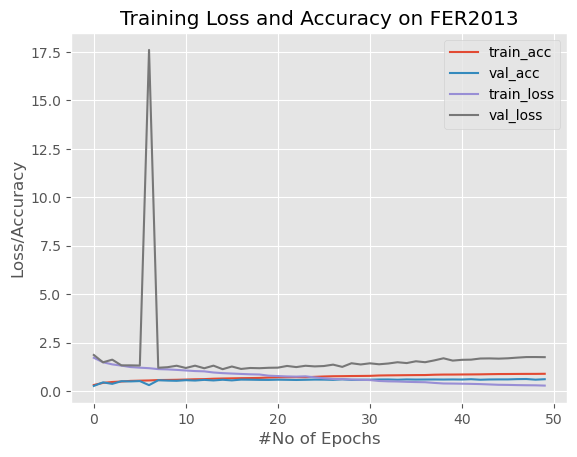

[INFO] evaluating network...
              precision    recall  f1-score   support

       angry       0.55      0.59      0.57       958
     disgust       0.70      0.58      0.63       111
        fear       0.51      0.48      0.50      1024
       happy       0.79      0.86      0.82      1774
     neutral       0.59      0.60      0.59      1233
         sad       0.54      0.43      0.48      1247
    surprise       0.75      0.81      0.78       831

    accuracy                           0.64      7178
   macro avg       0.63      0.62      0.62      7178
weighted avg       0.63      0.64      0.63      7178

[INFO] Final Test Accuracy = 0.6391752577319587


<Figure size 640x480 with 0 Axes>

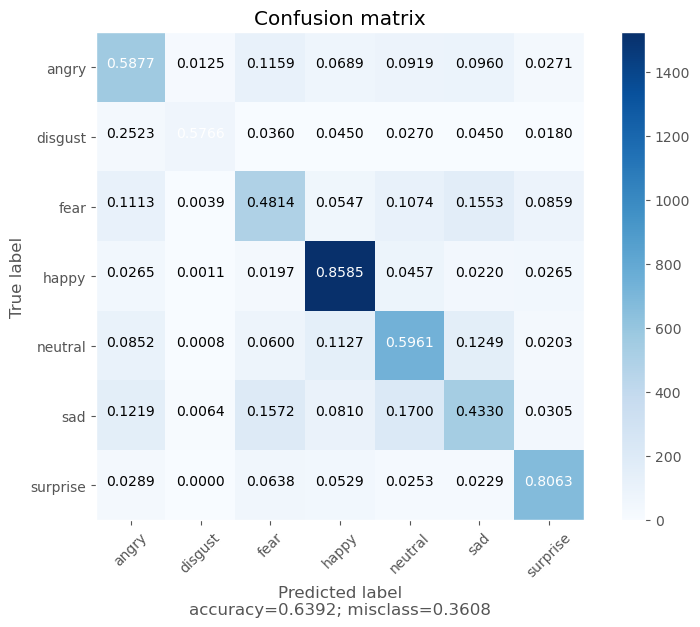

In [7]:
if device == cfg.GPU_STR:
    model = model.to(cfg.CPU_STR)
torch.save(model.state_dict(), f'{cfg.RESULTS_DIRECTORY}/{cfg.MODEL_FILE}')
# plot the training loss and accuracy overtime
plt.style.use("ggplot")
plt.figure()
plt.plot(history['train_acc'], label='train_acc')
plt.plot(history['val_acc'], label='val_acc')
plt.plot(history['train_loss'], label='train_loss')
plt.plot(history['val_loss'], label='val_loss')
plt.ylabel('Loss/Accuracy')
plt.xlabel("#No of Epochs")
plt.title('Training Loss and Accuracy on FER2013')
plt.legend(loc='upper right')
plt.show()
plt.savefig(f'{cfg.RESULTS_DIRECTORY}/{cfg.PLOT_FILE}')

# evaluate the model based on the test set
model = model.to(device)
with torch.set_grad_enabled(False):
    # set the evaluation mode
    model.eval()

    # initialize a list to keep track of our predictions
    predictions = []

    # iterate through the test set
    for (data, _) in test_loader:
        # move the data into the device used for testing
        data = data.to(device)

        # perform a forward pass and calculate the training loss
        output = model(data)
        output = output.argmax(axis=1).cpu().numpy()
        predictions.extend(output)

# evaluate the network
print("[INFO] evaluating network...")
actual = [label for _, label in test_data]
print(classification_report(actual, predictions, target_names=test_data.classes))
con_mat = confusion_matrix(actual, predictions)
plot_confusion_matrix(con_mat, test_data.classes)
test_acc = (predictions == np.array(actual)).sum() / len(predictions)
print(f"[INFO] Final Test Accuracy = {test_acc}")